# Majority Voting Experiments

Majority voting is the default voting technique used in simple crowdsourcing systems.
In this notebook, we also experiment with a few simple techniques which rely on also looking at similar documents when aggregating votes.


## TODO
 * Aggregate over topics and repeats (50-60ish)
 * Plot multiple curves on same graph.
 * RMSE evaluation of MVNN, compared to data in paper.
 * Sort out some of the code duplication.

In [1]:
%load_ext autoreload

In [2]:
from collections import OrderedDict
import datetime
import io
import os
import random
import sys

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

print("Current Python: {0}".format(sys.executable))

# This makes Jupyter pretend to be Pythonic and play well with modules.
sys.path.append(os.path.expandvars(os.path.join(os.getcwd(), '..')))

Current Python: /Users/andrei/anaconda3/envs/crowd/bin/python


In [3]:
np.random.seed(0xF00F1E2)
random.seed(0xF00F1E2)

In [4]:
%autoreload 2

from crowd.data import *
from crowd.config import *
from crowd.file_util import *
from crowd.graph import *
from crowd.topic import *
from crowd.simulation import *

## Load data

In [5]:
SIM_THRESHOLD = 0.5

id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
test_data = read_all_test_labels()
id_topic_graph = {topic_id: build_document_graph(topic, FULLTEXT_FOLDER, sim_threshold=SIM_THRESHOLD)
                  for topic_id, topic in id_topic_info.items()}

In [6]:
print("{0} total useful votes, a.k.a. judgements.".format(len(judgements)))

46319 total useful votes, a.k.a. judgements.


In [7]:
COIN_FLIP = "COIN_FLIP"

In [8]:
def count_votes(votes):
    relevant_votes = 0
    non_relevant_votes = 0
    for vote in votes:
        if vote.is_relevant > 0:
            relevant_votes += 1
        elif vote.is_relevant == 0:
            non_relevant_votes += 1
        else:
            raise ValueError("Non 0/1 vote.")
    
    return relevant_votes, non_relevant_votes

In [9]:
def full_mv_aggregation(document_id, topic_judgements):
    """Computes the voter consensus for the specified document.
    
    Calculation perform directly on all votes, without relying on any
    sampling.
    """
    
    if document_id not in topic_judgements:
        raise ValueError("Document ID#{0} doesn't have any votes to "
                         "aggregate.".format(document_id))
        
    votes = topic_judgements[document_id]
    rel_votes, non_rel_votes = count_votes(votes)

    if rel_votes == 0 and non_rel_votes == 0:
        raise ValueError("No votes for ground truth document ID#{0}. That's a "
                         "shame.".format(document_id))
        
    return rel_votes >= non_rel_votes

## Majority Voting Aggregation

In [10]:
def aggregate_MV(topic_graph, all_sampled_votes, **kw):
    """The default way of aggregating crowdsourcing votes.
    
    Args:
        topic_graph: The current topic's document graph. Not used.
        all_sampled_votes: A map from document ID to a list of
            'JudgementRecord's which have been sampled so far in our
            simulation.
        
    Returns:
        A map which contains a boolean relevance for every document.
    """
       
    return {document_id: majority(document_votes)
            for (document_id, document_votes) in all_sampled_votes.items()}
            
    
def majority(votes, tie_handling=COIN_FLIP):
    """Computes the majority of a list of 'JudgementRecord's.
    
    Args:
        votes: A list of 'JudgementRecord' objects.
        tie_handling: An enum specifying how ties are to be treated.
    
    Returns:
        A boolean indicating whether the consensus is "relevant".
        Ties are broken as specified by the 'tie_handling' parameter.
        
    """
    # Note: mind the Nones!
    relevant = len([vote for vote in votes if vote.is_relevant == True])
    non_relevant = len([vote for vote in votes if vote.is_relevant == False])
    
    if relevant > non_relevant:
         return True
    elif relevant < non_relevant:
         return False
    elif tie_handling == COIN_FLIP:
        return random.choice([True, False])
    else:
        raise ValueError("Unknown tie handling technique: [{}]."
                         .format(tie_handling))

## MV with Nearest Neighbor

* for all $i \in I$ (documents) do
    * if $i$ has no votes
        * $\hat{p_i} \leftarrow 0.5$
    * else
        * if $\rho(d_i, d_{o^i(2)}) > \rho_s$ then
            * $\hat{p_i} \leftarrow \overline{V_i \cup V_{o^i(2)}}$
        * else
            * $\hat{p_i} \leftarrow \overline{V_i}$
        * end if
    * end if
* end for

In [16]:
def aggregate_MV_NN(topic_graph, all_sampled_votes, **kw):
    """Majority voting which tries to steal votes from the closest neighbor.
    
    This method is similar to 'aggregate_MV', but also tries to take some
    document similarity information into account.
    
    Args:
        topic_graph: The current topic's document graph. Not used.
        all_sampled_votes: A map from document ID to a list of sampled
            'JudgementRecord's.
        rho_s: The similarity threshold below which we ignore the nearest
            neighbor.
        seek_good_neighbor: Enables a more thorough nearest neighbor search,
            not stopping at the very first neighbor, but at the nearest
            neighbor which also has at least 'min_votes' votes.
        
    Returns:
        A map which contains a boolean relevance for every document.
    """
    
    rho_s = kw.get('rho_s', 0.9)
    del kw['rho_s'] # TODO(andrei) Do this in a nicer way.
    seek_good_neighbor = kw.get('seek_good_neighbor', False)
    
    if seek_good_neighbor:
        aggregator = majority_with_nn_seek
    else:
        aggregator = majority_with_nn
        
    return {document_id: aggregator(topic_graph, document_id,
                                    document_votes, all_sampled_votes,
                                    rho_s, **kw)
            for (document_id, document_votes) in all_sampled_votes.items()}


def majority_with_nn(topic_graph, doc_id, votes, all_sampled_votes, rho_s, **kw):
    node = topic_graph.get_node(doc_id)
    
    if len(node.neighbors) == 0:
        # No neighbors in graph.
        return majority(votes)
    
    nn = node.sim_sorted_neighbors[0]
    if nn.similarity < rho_s:
        # Nearest neighbor is not near enough.
        return majority(votes)
    
    if nn.to_document_id not in all_sampled_votes:
        # Neighbor has no votes.
        # Note: The original MVNN code simply looks at the most similar
        # neighbor, and adds its votes. If it has no votes, then tough luck.
        return majority(votes)
    
    neighbor_votes = all_sampled_votes[nn.to_document_id]
    return majority(votes + neighbor_votes)


def majority_with_nn_seek(topic_graph, doc_id, votes, all_sampled_votes, rho_s,
                          **kw):
    """Seeks the nearest neighbor which also has some votes."""
    node = topic_graph.get_node(doc_id)
    min_votes = kw.get('min_votes', 1)
    
    if len(node.neighbors) == 0:
        # No neighbors in graph.
        return majority(votes)
    
    index = 0
    while index < len(node.neighbors):
        nn = node.sim_sorted_neighbors[index]
        index += 1

        if nn.similarity < rho_s:
            # Nearest neighbor is not near enough.
            continue
            
        if nn.to_document_id not in all_sampled_votes:
            # Neighbor has no vote data.
            continue

        neighbor_votes = all_sampled_votes[nn.to_document_id]
        if len(neighbor_votes) < min_votes:
            # Neighbor doesn't have enough votes for us to care.
            continue
        
        # Found a good neighbor. Stop the search.
        return majority(votes + neighbor_votes)
            
    # No good neighbor found.
    return majority(votes)

## Merge Enough Votes (MEV)

In [26]:
def mev_aggregator(topic_graph, doc_id, votes, all_sampled_votes, **kw):
    """Performs vote aggregation using the 'MergeEnoughVotes' technique.
    
    Kwargs:
        C: The desired vote count.
    """
    C = kw.get('C', 1)
    node = topic_graph.get_node(doc_id)
    
    if len(node.neighbors) == 0 or len(votes) >= C:
        return majority(votes)
    
    # $U_i$ = augmented_votes
    # Make sure we don't modify the original vote list.
    augmented_votes = list(votes)
    
    # Merge the most similar neighbor's votes first.
    for nn in node.sim_sorted_neighbors:
        votes_left = C - len(augmented_votes)
        if votes_left <= 0:
            break
            
        if nn.to_document_id not in all_sampled_votes:
            # Neighbor has no vote data.
            continue
            
        # TODO(andrei): Experiment with similarity thresholding here.
            
        nn_votes = all_sampled_votes[nn.to_document_id]
        # We ensure we don't merge too many votes.
        augmented_votes += nn_votes[:votes_left]
        
    return majority(augmented_votes)

In [27]:
def aggregate_MEV(topic_graph, all_sampled_votes, **kw):
    """
        
    Returns:
        A map which contains a boolean relevance for every document.
    """
    return {document_id: mev_aggregator(topic_graph, document_id,
                                        document_votes, all_sampled_votes,
                                        **kw)
            for (document_id, document_votes) in all_sampled_votes.items()}

## Measurement Utilities

In [28]:
def build_learning_curve(topic_id, aggregation_function, **kw):
    """Returns a numpy array with growing accuracy, up to 'max_votes'."""
    
    topic = id_topic_info[topic_id]
    graph = id_topic_graph[topic_id]
    topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
    topic_ground_truth = {truth.document_id: truth for truth in test_data
                          if truth.topic_id == topic_id}
    

    # i.e. up to target_votes votes per doc, on average.
    # TODO(andrei) Make this cleaner and more seamless.
    max_votes = kw['max_votes'] if 'max_votes' in kw else 3
    bud = len(topic_judgements) * max_votes
    acc = evaluate(
        graph,
        topic_judgements,
        topic_ground_truth,
        LeastVotesSampler(),
        aggregation_function,
        budget=bud,
        **kw)

    # Note: this result is still indexed by-vote.
    acc = np.array(acc)
    acc_avg = np.mean(acc, axis=0)        
    return acc_avg


def learning_curve_frame(topic_id, aggregation, label, document_count, **kw):
    """Helper proxy for 'build_learning_curve'.
    
    Wraps its result in a pandas dataframe, and normalizes the index so that
    it represents average votes per document. This makes it much, much easier
    to perform e.g. cross-topic aggregations, when different topics have
    different document counts (which means we need different numbers of votes
    in order to reach the same mean nr. votes per document).
    """
    
    # In votes_per_doc space.
    # TODO(andrei): Document this stuff.
    acc_avg = build_learning_curve(topic_id, aggregation, **kw)
    sample_count = kw.get('sample_count', 100)
    frame = pd.DataFrame({label: acc_avg})
    new_index = np.linspace(0, len(acc_avg) / document_count, sample_count)
    acc_avg_resampled = np.interp(
        new_index,
        # Sampling x coords
        np.linspace(0, len(acc_avg) / document_count, len(acc_avg)),
        # Values to sample
        acc_avg)
    classic = frame
    frame = pd.DataFrame({label: acc_avg_resampled}, index=new_index)
    
#     return frame, classic
    return frame


# This code showcases the (very small) discrepancy between the original dataset
# and the resampled one.
# f, classic = learning_curve_frame(
#     '20424', 
#     mv_config.vote_aggregator,
#     "lbl",
#     len(get_topic_judgements_by_doc_id('20424', judgements)))
# plt.plot(f.index, f['lbl'])
# plt.plot(classic.index / 100.0, classic['lbl'])

In [29]:
class ExperimentConfig(object):    
    def __init__(self, vote_aggregator, name, params):
        self.vote_aggregator = vote_aggregator
        self.name = name
        self.params = params

In [33]:
mv_config = ExperimentConfig(aggregate_MV, "MV", {})
mv_nn_config = ExperimentConfig(aggregate_MV_NN, "MVNN(0.5)", {'rho_s': 0.5})
mv_nn_09_config = ExperimentConfig(aggregate_MV_NN, "MVNN(0.9)", {'rho_s': 0.9})
mv_nn_plus = ExperimentConfig(aggregate_MV_NN, "MVNN+(0.9)", {'rho_s': 0.9, 'seek_good_neighbor': True})
mv_nn_plus_hardcore = ExperimentConfig(aggregate_MV_NN, "MVNN+(0.995)", {'rho_s': 0.995, 'seek_good_neighbor': True})
mev_1_config = ExperimentConfig(aggregate_MEV, "MEV(1)", {'C': 1})
mev_2_config = ExperimentConfig(aggregate_MEV, "MEV(2)", {'C': 2})
mev_3_config = ExperimentConfig(aggregate_MEV, "MEV(3)", {'C': 3})
mev_4_config = ExperimentConfig(aggregate_MEV, "MEV(4)", {'C': 4})
mev_5_config = ExperimentConfig(aggregate_MEV, "MEV(5)", {'C': 5})

def plot_topic(topic_id, experiments, max_votes, iterations, **kw):
    topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
    document_count = len(topic_judgements)
    cframe = pd.DataFrame()
    
    for cfg in experiments:
        subframe = learning_curve_frame(
            topic_id,
            cfg.vote_aggregator,
            cfg.name,
            document_count,
            iterations=iterations,
            max_votes=max_votes,
            sample_count=kw.get('sample_count'),
            **cfg.params)
        cframe = pd.concat([cframe, subframe])
        
    ax = cframe.plot(marker=kw.get('marker'), fontsize=12)    
    ax.set_xlabel("Mean votes per document")
    ax.set_ylabel("Accuracy")
    ax.legend(loc='lower right')

In [ ]:
fmt_topic = lambda t: "[%s] %s (%d)" % (t.topic_id, t.query, t.document_count)
optlist = ((fmt_topic(t), t.topic_id) for t in id_topic_info.values())
options=OrderedDict(sorted(optlist))

import pylab
pylab.rcParams['figure.figsize'] = (18, 9)

# MVNN+(0.9)
# See: 20584 with VERY FEW votes
# See: 20694 with VERY FEW votes
# See: 20780 with VERY FEW votes. Starts really sucking after 1.0, especially around 3.0.
# See: 20956: beats opponents 1-3
# 20972 Highlights poor performance of MVNN(0.5) vs MVNN(0.9)
# vice president Richard Nixon seems to yield very poor results across the board.
#     Need to manually inspect data. Perhaps it's because results about Nixon 
#     as a president seem relevant but actually are not?

@interact(
    topic_id=widgets.Dropdown(options=options, value='20704'),
    iterations=widgets.IntSlider(min=10, max=500, step=5, continuous_update=False, value=25),
    max_votes_per_doc=widgets.IntSlider(min=1, max=10, step=1, continuous_update=False, value=1)
)
def plot_proxy(topic_id, iterations, max_votes_per_doc):
    print("Iterations: %d" % iterations)
    experiments = [#mv_config, 
                   mv_nn_config,
                   #mv_nn_09_config,
                   mv_nn_plus,
                   mev_1_config,
                   mev_2_config,
                   mev_3_config]
    plot_topic(topic_id, experiments, max_votes_per_doc, iterations, sample_count=750)

Iterations: 25


## Aggregation over topics

Very slow to compute. Should calculate on Euler.

In [22]:
def plot_all(experiments, max_votes, iterations):
    cframe = pd.DataFrame()
    for cfg in experiments:
        frame = cross_topic_learning_curve_frame(
            cfg.vote_aggregator,
            cfg.name,
            iterations=iterations,
            max_votes=max_votes,
            **cfg.params)
#         plt.plot(np.arange(0, res.shape[0]), res)
        cframe = pd.concat([cframe, frame])
    
    ax = cframe.plot()
    plt.legend(loc='lower right')
    

# TODO(andrei) Rename this to reflect frameness.
def cross_topic_learning_curve_frame(aggregation_function, label, **kw):
    curves = []
    index = None

    print("Processing aggregator: {0}.".format(label))
    topic_count = len(id_topic_info)
    for idx, (topic_id, topic) in enumerate(id_topic_info.items()):
        topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
        document_count = len(topic_judgements)
        curve = learning_curve_frame(topic_id, aggregation_function, label, document_count, **kw)
        curves.append(curve[label])
        index = curve.index
        
        if idx % 5 == 0:
            print("Processing topic number {0}/{1}.".format(idx, topic_count))
    
    curves = np.array(curves)
    print(curves.shape)
    means = np.mean(curves, axis=0)
    return pd.DataFrame({label: means}, index=index)

Processing aggregator: MV.
Processing topic number 0/30.
Processing topic number 5/30.
Processing topic number 10/30.
Processing topic number 15/30.
Processing topic number 20/30.
Processing topic number 25/30.
(30, 100)
Processing aggregator: MVNN(0.5).
Processing topic number 0/30.
Processing topic number 5/30.
Processing topic number 10/30.
Processing topic number 15/30.
Processing topic number 20/30.
Processing topic number 25/30.
(30, 100)
Processing aggregator: MVNN+(0.9).
Processing topic number 0/30.
Processing topic number 5/30.
Processing topic number 10/30.
Processing topic number 15/30.
Processing topic number 20/30.
Processing topic number 25/30.
(30, 100)


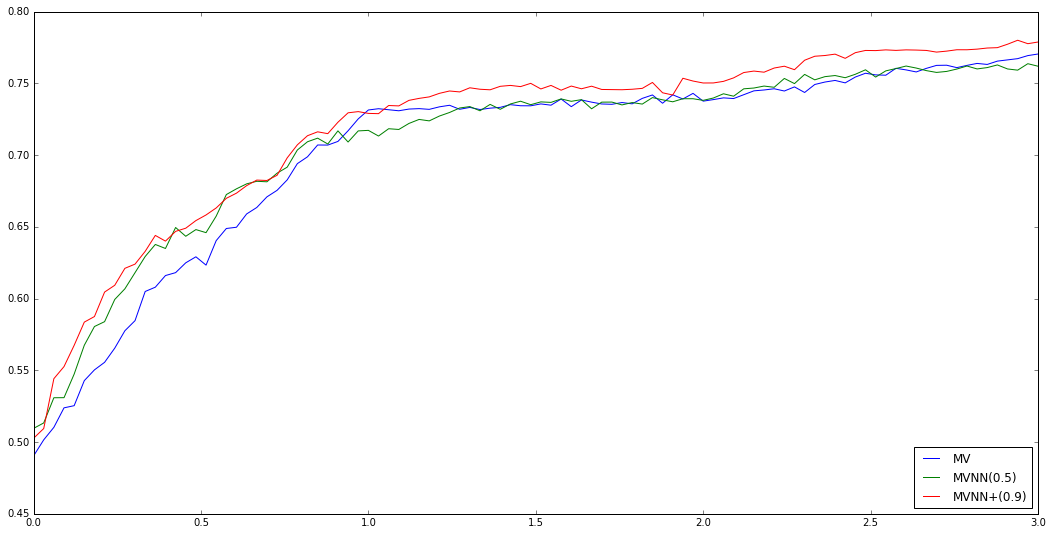

In [23]:
plot_all([mv_config, mv_nn_config, mv_nn_plus], 3, 25)

## Comparison with paper gold standard

In [24]:
after_one_vote = {}
topic_count = len(id_topic_info)

for i, (topic_id, topic) in enumerate(id_topic_info.items()):
    print("Topic %d/%d" % (i + 1, topic_count))
    data = build_learning_curve(
        topic_id,
        aggregate_MV,
        iterations=1000,
        max_votes=1,
        progress_every=-1)

    after_one_vote[topic_id] = data[-1]    

Topic 1/30
Topic 2/30
Topic 3/30
Topic 4/30
Topic 5/30
Topic 6/30
Topic 7/30
Topic 8/30
Topic 9/30
Topic 10/30
Topic 11/30
Topic 12/30
Topic 13/30
Topic 14/30
Topic 15/30
Topic 16/30
Topic 17/30
Topic 18/30
Topic 19/30
Topic 20/30
Topic 21/30
Topic 22/30
Topic 23/30
Topic 24/30
Topic 25/30
Topic 26/30
Topic 27/30
Topic 28/30
Topic 29/30
Topic 30/30


In [25]:
paper_standard_mv = {
    '20424': 0.594,
    '20488': 0.667,
    '20542': 0.676,
    '20584': 0.689,
    '20636': 0.716,
    '20642': 0.693,
    '20686': 0.693,
    '20690': 0.703,
    '20694': 0.726,
    '20696': 0.562,
    '20704': 0.670,
    '20714': 0.808,
    '20764': 0.676,
    '20766': 0.796,
    '20778': 0.652,
    '20780': 0.641,
    '20812': 0.688,
    '20814': 0.792,
    '20832': 0.630,
    '20910': 0.661,
    '20916': 0.650,
    '20932': 0.576,
    '20956': 0.616,
    '20958': 0.610,
    '20962': 0.552,
    '20972': 0.668,
    '20976': 0.632,
    '20996': 0.542
}

# TODO(andrei) 
paper_standard_mvnn_05 = {
    '20424': 0.608,
    '20488': 0.722,
    '20542': 0.673,
    '20584': 0.761, #*
    '20636': 0.774, #*
    '20642': 0.756, #*
    '20686': 0.639,
    
    '20690': 0.744, #*
    '20694': 0.746,
    '20696': 0.622,
    '20704': 0.790, #*
    '20714': 0.818,
    '20764': 0.600,
    '20766': 0.794,
    '20778': 0.662,
    '20780': 0.732, #*
    '20812': 0.695,
    '20814': 0.770,
    '20832': 0.642,
    '20910': 0.643,
    '20916': 0.638,
    '20932': 0.540,
    '20956': 0.646,
    '20958': 0.556,
    '20962': 0.610,
    '20972': 0.632,
    '20976': 0.620,
    '20996': 0.504
}

def rmse_own_results(own_result_map):
    rmse = 0.0
    for topic_id, mv_score in paper_standard_mv.items():
        rmse += abs(own_result_map[topic_id] - mv_score) ** 2
    
    rmse /= len(paper_standard_mv)
    return rmse

In [26]:
print(rmse_own_results(after_one_vote))

0.00990155772575


### RMSE for MV
* rmse = 0.44473 when comparing all votes to 0.0
* rmse = 0.03119 when comparing all votes to 0.5
* rmse = 0.01002 when running 500 iterations (30 Apr)
* rmse = 0.00989 when running 1000 iterations (30 Apr)